In [118]:
# import gurobipy as gp
# from gurobipy import GRB
# import logging

# logger = logging.getLogger('logger')
# logger.setLevel(logging.INFO)


# def calculate_revenue(da_price, ss_price, energy, energy_label, bid=None):

#     # Calculate price difference
#     price_diff = da_price - ss_price

#     if bid != None:
#         # Calculate revenue with a given bid (no optimization)
#         revenue = ss_price * energy_label + price_diff * bid - 0.07 * (energy_label - bid) * (energy_label - bid)

#         return bid, revenue

#     elif bid == None:
#         # Create Gurobi model
#         model = gp.Model("OptimalBid")

#         # Add bid variable to optimize
#         bid = model.addVar(name="bid")

#         # Define valid boundaries
#         lb_constraint = model.addConstr(bid >= 0, name="lower_bound")
#         ub_constraint = model.addConstr(bid <= 1800, name="upper_bound")

#         # Define revenue function
#         revenue_obj = ss_price * energy + price_diff * bid - 0.07 * (energy - bid) * (energy - bid)

#         # Set objective to maximize revenue function
#         model.setObjective(revenue_obj, GRB.MAXIMIZE)

#         # Add the KKT condition as a constraint (Gradient must be 0)
#         model.addConstr(price_diff + 0.14 * (energy - bid) == 0, "KKT")

#         # Optimize model
#         model.optimize()

#         # Check if optimal solution was found
#         if model.status == GRB.OPTIMAL:
            
#             # Manual case distinction
#             if lb_constraint.Pi == 0 and ub_constraint.Pi == 0:
#                 optimal_bid = energy + 7.14 * price_diff
#                 # Adjust solution if it's outside the valid boundaries
#                 optimal_bid = min(max(optimal_bid, 0), 1800)

#             elif lb_constraint.Pi != 0 and ub_constraint.Pi == 0:
#                 optimal_bid = 0

#             elif lb_constraint.Pi == 0 and ub_constraint.Pi != 0:
#                 optimal_bid = 1800

#         else:
#             optimal_bid = energy + 7.14 * price_diff
#             optimal_bid = min(max(optimal_bid, 0), 1800)
#             #optimal_bid = energy

#         # Calculate revenue that would have been generated under real conditions
#         bid = optimal_bid
#         revenue = ss_price * energy_label + price_diff * optimal_bid - 0.07 * (energy_label - optimal_bid)**2

#         return bid, revenue


In [119]:
import logging

logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)

### Function to calculate generated revenue for a given bid

In [120]:
def calculate_revenue(da_price_label, ss_price_label, energy_label, price_diff_pred=None, energy_pred=None, bid=None, best_possible=False):
    """Calculates the revenue that would have been generated for a given bid"""
    
    # Calculate price difference between DA-price and SS-price
    
    price_diff_label = da_price_label - ss_price_label

    if bid != None:
        # Calculate revenue that would have been generated for a given bid (no optimization)
        revenue = ss_price_label * energy_label + price_diff_label * bid - 0.07 * (energy_label - bid)**2
        return bid, revenue

    elif bid == None:
        # Calculate optimal bidding value decision
        if best_possible:
            optimal_bid = energy_label + 7.14 * price_diff_label
        else:
            optimal_bid = energy_pred + 7.14 * price_diff_pred
        # Keep the calculated bid within the valid boundaries
        optimal_bid = min(max(optimal_bid, 0), 1800)
        # Calculate revenue that would have been generated for the optimized bid
        revenue = ss_price_label * energy_label + price_diff_label * optimal_bid - 0.07 * (energy_label - optimal_bid)**2

        return optimal_bid, revenue


### Function to optimize Bidding Value

In [121]:
def optimize_bid(da_price, ss_price, energy):
    """Optimizes the bidding value decision depending on the forecast results of energy production, Day-Ahead price and Single-System Price"""
    
    # Calculate price difference between DA-price and SS-price
    price_diff = da_price - ss_price
    # Calculate optimal bidding value decision
    optimal_bid = energy + 7.14 * price_diff
    # Keep the calculated bid within the valid boundaries
    optimal_bid = min(max(optimal_bid, 0), 1800)
    
    return optimal_bid

### Merging Energy Forecasts with Labels

In [122]:
from model_utils import *
from Preprocessing import FeatureEngineerer
import numpy as np

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe=['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit", columns_to_ohe=[])
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

wind_model = LGBMRegressorModel(feature_engineerer_wind, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_wind", load_pretrained=True)
solar_model = LGBMRegressorModel(feature_engineerer_solar, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_solar", load_pretrained=True)

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Loaded pretrained Q

In [123]:
df_energy = pd.read_csv("data/Energy_Data_20200920_20240118.csv")
df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])

df_pred_wind = pd.concat([pd.DataFrame(wind_model.predict(feature_engineerer_wind.X_test)), feature_engineerer_wind.y_test.reset_index()], axis=1)
df_pred_solar = pd.concat([pd.DataFrame(solar_model.predict(feature_engineerer_solar.X_test)), feature_engineerer_solar.y_test.reset_index()], axis=1)

df_pred = pd.merge(df_pred_wind, df_pred_solar, on="dtm", how="inner", suffixes=("_wind", "_solar"))

for column in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']:
    df_pred[column] = df_pred[f"{column}_wind"] + df_pred[f"{column}_solar"]
df_pred = df_pred.drop(['0.1_wind', '0.2_wind', '0.3_wind', '0.4_wind', '0.5_wind', '0.6_wind',
                        '0.7_wind', '0.8_wind', '0.9_wind', '0.1_solar', '0.2_solar', '0.3_solar', '0.4_solar', '0.5_solar',
                        '0.6_solar', '0.7_solar', '0.8_solar', '0.9_solar'], axis=1)

df_pred["energy_label"] = df_pred["Wind_MWh_credit"] + df_pred["Solar_MWh_credit"]
df_pred = df_pred.drop(["Wind_MWh_credit", "Solar_MWh_credit"], axis=1)

df_final = df_pred.merge(df_energy, on="dtm", how="left")
df_final = df_final.drop(["MIP", "Solar_MW", "Solar_capacity_mwp", "Solar_installedcapacity_mwp", "Wind_MW", "boa_MWh"], axis=1)
df_final = df_final.rename(columns={"SS_Price": "ss_price_label", "DA_Price": "da_price_label"})

### Loading Models to predict price difference

In [124]:
import joblib

lr_price_model = joblib.load('price_models/linear_regression_model.pkl')
rfr_price_model = joblib.load('price_models/random_forest_model.pkl')
gbr_price_model = joblib.load('price_models/gradient_boosting_model.pkl')
lgbm_price_model = joblib.load('price_models/lgbm_model.pkl')

X_test_price = joblib.load('price_data/X_test.pkl')
y_test_price = joblib.load('price_data/y_test.pkl')

### Adding Model results to dataframe

In [125]:
for model, column_name in {lr_price_model: "price_diff_lr", 
              rfr_price_model: "price_diff_rfr", 
              gbr_price_model: "price_diff_gbr"}.items():
    pred = pd.DataFrame(model.predict(X_test_price), columns=[column_name])
    pred = pd.concat([pred, y_test_price.reset_index()["dtm"]], axis=1)
    pred = pred.drop_duplicates()
    df_final = pd.merge(df_final, pred, on="dtm", how="left").drop_duplicates()

In [126]:
lgbm_pred = pd.DataFrame(lgbm_price_model.predict(X_test_price)["0.4"], columns=["price_diff_lgbm"])
lgbm_pred = pd.concat([lgbm_pred, y_test_price.reset_index()["dtm"]], axis=1)
lgbm_pred = lgbm_pred.drop_duplicates()
df_final = pd.merge(df_final, lgbm_pred, on="dtm", how="left").drop_duplicates()

### Calculating revenues for different Bidding Strategies

In [127]:
df_final["revenue_05_bid"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                           ss_price_label=row["ss_price_label"],
                                                                           energy_label=row["energy_label"],
                                                                           bid=row[f"0.5"])[1],
                                                                           axis=1)

df_final["revenue_best_possible_bid"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                                     ss_price_label=row["ss_price_label"], 
                                                                                     energy_label=row["energy_label"],
                                                                                     best_possible=True)[1],
                                                                                     axis=1)

df_final["revenue_optimized_bid_lr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                                 ss_price_label=row["ss_price_label"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_lr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_rfr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                                 ss_price_label=row["ss_price_label"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_rfr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_gbr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                                 ss_price_label=row["ss_price_label"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_gbr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_lgbm"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["da_price_label"], 
                                                                                 ss_price_label=row["ss_price_label"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_lgbm"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

In [128]:
print(f"Optimized revenue with linear regression model for price difference:  {round(df_final['revenue_optimized_bid_lr'].mean(), 3)}")
print(f"Optimized revenue with random forest regressor for price difference:  {round(df_final['revenue_optimized_bid_rfr'].mean(), 3)}")
print(f"Optimized revenue with gradient bossting model for price difference:  {round(df_final['revenue_optimized_bid_gbr'].mean(), 3)}")
print(f"Optimized revenue with lgbm model for price difference:               {round(df_final['revenue_optimized_bid_lgbm'].mean(), 3)}")
print(f"Revenue with 0.5 quantile bid:                                        {round(df_final['revenue_05_bid'].mean(), 3)}")
print(f"Best possible revenue:                                                {round(df_final['revenue_best_possible_bid'].mean(), 3)}")

Optimized revenue with linear regression model for price difference:  27702.611
Optimized revenue with random forest regressor for price difference:  27044.31
Optimized revenue with gradient bossting model for price difference:  26123.612
Optimized revenue with lgbm model for price difference:               28312.854
Revenue with 0.5 quantile bid:                                        28257.292
Best possible revenue:                                                35938.677


### Plotting results

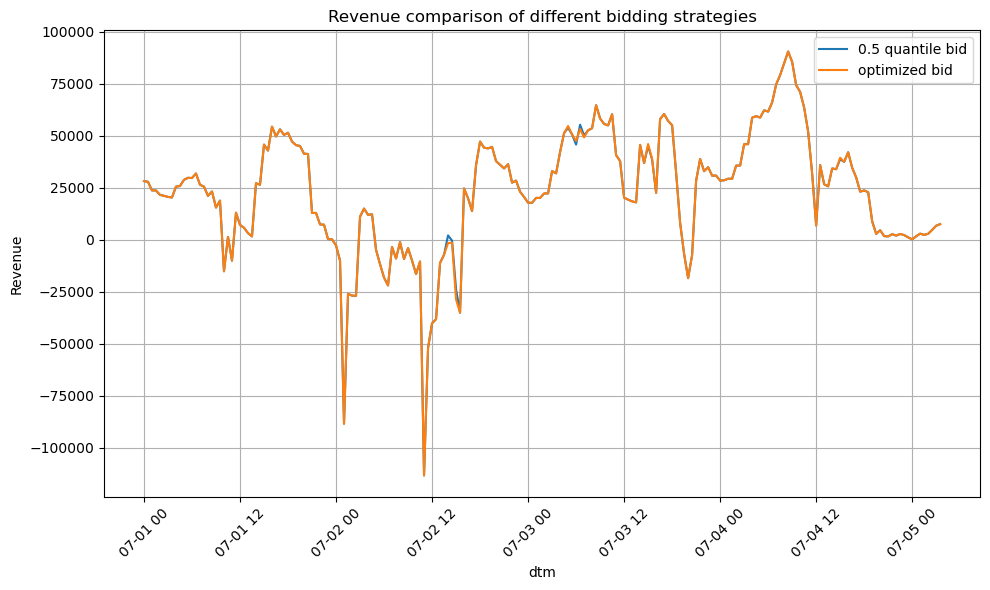

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_reduced = df_final[:200]
plt.plot(df_reduced['dtm'], df_reduced['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_reduced['dtm'], df_reduced['revenue_optimized_bid_lgbm'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

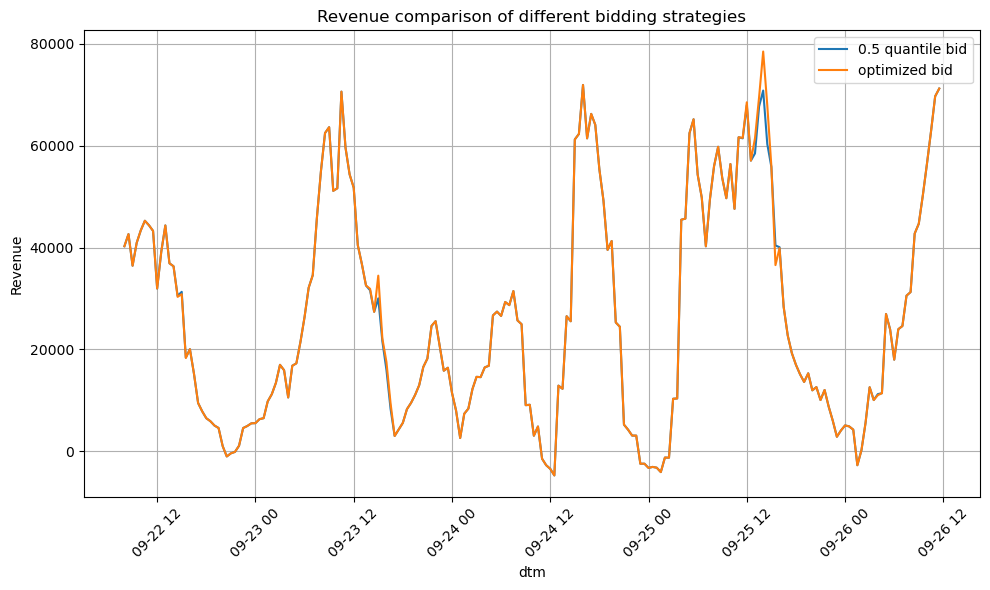

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_reduced = df_final[4000:4200]
plt.plot(df_reduced['dtm'], df_reduced['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_reduced['dtm'], df_reduced['revenue_optimized_bid_lgbm'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

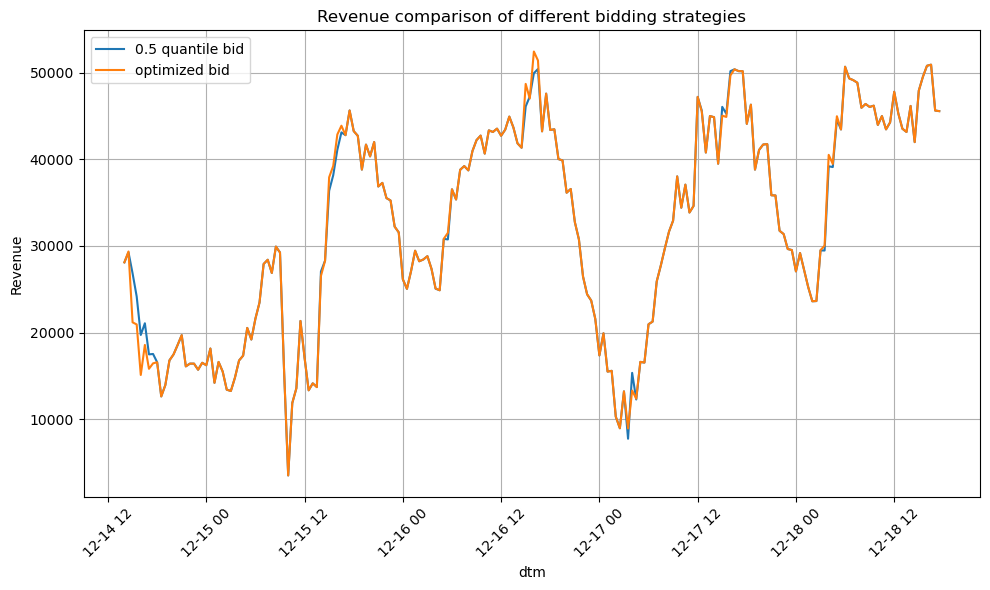

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_reduced = df_final[8000:8200]
plt.plot(df_reduced['dtm'], df_reduced['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_reduced['dtm'], df_reduced['revenue_optimized_bid_lgbm'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

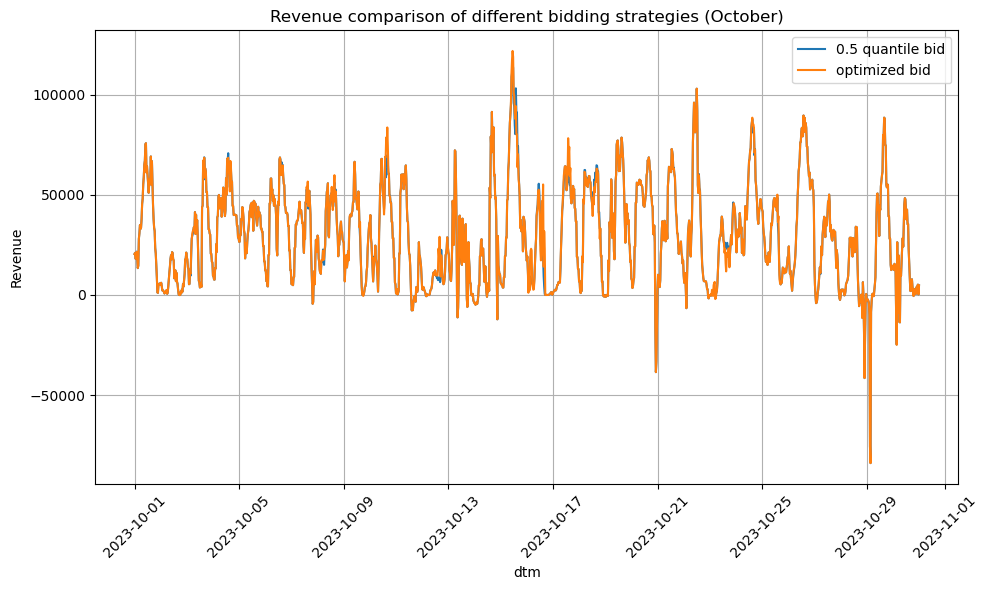

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_reduced = df_final[(df_final["dtm"] >= "2023-10-01") & (df_final["dtm"] <= "2023-10-31")]
plt.plot(df_reduced['dtm'], df_reduced['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_reduced['dtm'], df_reduced['revenue_optimized_bid_lgbm'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies (October)')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

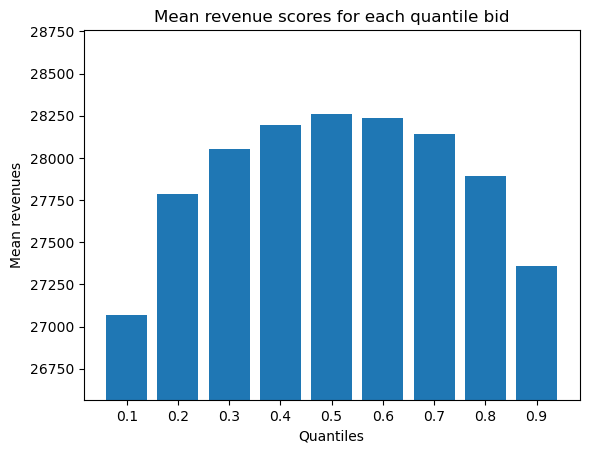

In [133]:
mean_bid_revenues = {}
for quantile in range(1, 10):
    mean_bid_revenues[f"0.{quantile}"] = df_final.apply(lambda row: calculate_revenue(
                                                da_price_label=row["da_price_label"], 
                                                ss_price_label=row["ss_price_label"],
                                                energy_label=row["energy_label"],
                                                bid=row[f"0.{quantile}"])[1],
                                                axis=1).mean()

plt.bar(mean_bid_revenues.keys(), mean_bid_revenues.values())
plt.ylim(min(mean_bid_revenues.values()) - 500, max(mean_bid_revenues.values()) + 500)
plt.title("Mean revenue scores for each quantile bid")
plt.xlabel("Quantiles")
plt.ylabel("Mean revenues")

plt.show()

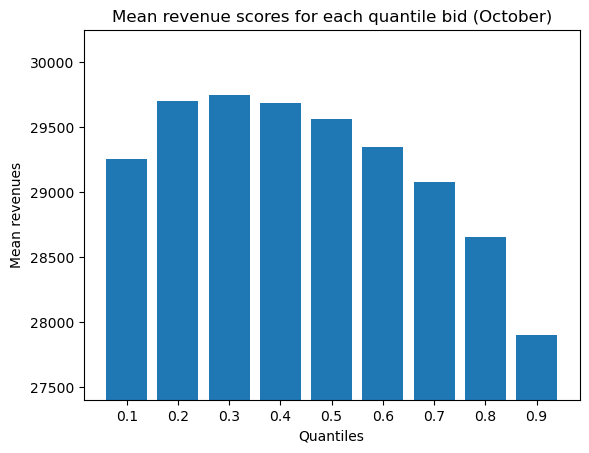

In [134]:
df_final_october = df_final[(df_final["dtm"] >= "2023-10-01") & (df_final["dtm"] <= "2023-10-31")]

mean_bid_revenues = {}
for quantile in range(1, 10):
    mean_bid_revenues[f"0.{quantile}"] = df_final_october.apply(lambda row: calculate_revenue(
                                                da_price_label=row["da_price_label"], 
                                                ss_price_label=row["ss_price_label"],
                                                energy_label=row["energy_label"],
                                                bid=row[f"0.{quantile}"])[1],
                                                axis=1).mean()
    
plt.bar(mean_bid_revenues.keys(), mean_bid_revenues.values())
plt.ylim(min(mean_bid_revenues.values()) - 500, max(mean_bid_revenues.values()) + 500)
plt.title("Mean revenue scores for each quantile bid (October)")
plt.xlabel("Quantiles")
plt.ylabel("Mean revenues")

plt.show()


In [20]:
# df_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

# df_energy_2 = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
# df_energy_3 = pd.read_csv("data\Energy_Data_20240119_20240519.csv")
# df_energy = pd.concat([df_energy_2, df_energy_3])

# df_energy = df_energy.rename(columns = {"timestamp_utc":"dtm"})
# df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])
# df_energy = df_energy.sort_values("dtm")
# grouped_means = df_energy.groupby([df_energy.dtm.dt.year, df_energy.dtm.dt.month, df_energy.dtm.dt.hour]).transform('mean')
# df_energy = df_energy.fillna(grouped_means)
# df_energy = df_energy[["dtm", "SS_Price", "DA_Price"]]
# df_energy = df_energy.drop_duplicates()

# df_demand_energy = df_energy.merge(df_demand, on="dtm", how="left")

# columns_to_drop = ['Solar_MWh_credit', 'Wind_MWh_credit', 'affectedUnit', 'availableCapacity', 'hoursSinceOutage', 'hoursUntilOutageEnd', 'outage', 'unavailabilityType',
#        'unavailableCapacity']
# df_demand_energy = df_demand_energy.drop(columns_to_drop, axis=1)
# df_demand_energy = df_demand_energy.set_index("dtm")

In [21]:
# df_demand_energy.columns

In [22]:
# df_demand_energy = df_demand_energy[["SS_Price", "DA_Price", "temp", "total_prec", "wind_dir_cos", "wind_dir_sin", "wind_speed"]]

In [23]:
# from Preprocessing import FeatureEngineerer

# feature_engineerer_ss_price = FeatureEngineerer(label = 'SS_Price', scaler_name="standard")
# feature_engineerer_ss_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

# feature_engineerer_da_price = FeatureEngineerer(label = 'DA_Price')
# feature_engineerer_da_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

In [24]:
# feature_engineerer_da_price.X_train.shape

In [25]:
# X_train_ss = feature_engineerer_ss_price.X_train
# X_test_ss = feature_engineerer_ss_price.X_test
# X_val_ss = feature_engineerer_ss_price.X_val
# y_val_ss = feature_engineerer_ss_price.y_val
# y_train_ss = feature_engineerer_ss_price.y_train
# y_test_ss = feature_engineerer_ss_price.X_train

In [26]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Angepasste Architektur mit Dropout und Batch Normalization
# class ImprovedNN(nn.Module):
#     def __init__(self):
#         super(ImprovedNN, self).__init__()
#         self.fc1 = nn.Linear(54, 128)  # 54 Eingabefeatures -> 128 Neuronen im Hidden Layer
#         self.bn1 = nn.BatchNorm1d(128) # Batch Norm nach dem ersten Layer
#         self.fc2 = nn.Linear(128, 64)  # 128 Neuronen -> 64 Neuronen im Hidden Layer
#         self.bn2 = nn.BatchNorm1d(64)  # Batch Norm nach dem zweiten Layer
#         self.fc3 = nn.Linear(64, 1)    # 64 Neuronen -> 1 Ausgabe (für Regression)
#         self.relu = nn.ReLU()          # ReLU-Aktivierung
#         self.dropout = nn.Dropout(p=0.3)  # Dropout mit 30% Wahrscheinlichkeit

#     def forward(self, x):
#         x = self.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

# # Initialisiere das Modell, den Loss und den Optimizer
# model = ImprovedNN()
# criterion = nn.MSELoss()  # MSE Loss für Regression
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Kleinere LR und L2 Regularisierung

# # Daten in Tensoren umwandeln
# X_train_tensor = torch.tensor(X_train_ss, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_ss, dtype=torch.float32).view(-1, 1)
# X_val_tensor = torch.tensor(X_val_ss, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_ss, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_ss, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_ss, dtype=torch.float32).view(-1, 1)

# # DataLoader erstellen
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Batch size auf 64 erhöht

# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Trainingsfunktion mit Early Stopping
# def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100, patience=10):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         val_loss = 0.0
#         model.eval()
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()

#         print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

#         # Early Stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0  # Reset patience counter
#             best_model = model.state_dict()  # Speichere das beste Modell
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             model.load_state_dict(best_model)  # Lade das beste Modell
#             break

# # Trainiere das Modell
# train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

# # Evaluation auf den Testdaten
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     print(f'Test Loss: {test_loss.item()}')
